In [30]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
from statsmodels.tsa.seasonal import seasonal_decompose

In [31]:
all_data_df = pd.read_csv('./../../../Databases/clean_data.csv')

In [32]:
all_data_df.head()

,Id,SiteId,Timestamp,TotalEntries,TotalOuts,TotalAccesses,TotalEntriesMen,TotalEntriesWoman,Temperature,Precipitation,Open/Closed
0,2305,2,2017-01-04 00:00:00,0,0,0,0.0,0.0,10.7,0.0,1
1,2306,2,2017-01-04 00:30:00,0,0,0,0.0,0.0,10.8,0.0,0
2,2307,2,2017-01-04 01:00:00,0,0,0,0.0,0.0,10.9,0.0,0
3,2308,2,2017-01-04 01:30:00,0,0,0,0.0,0.0,11.0,0.0,0
4,2309,2,2017-01-04 02:00:00,0,0,0,0.0,0.0,11.1,0.0,0


In [33]:
ravn_df = all_data_df[all_data_df['SiteId'] == 1][['Timestamp', 'TotalEntries', 'Temperature', 'Precipitation', 'Open/Closed']]
ravn_df['Timestamp'] = pd.to_datetime(ravn_df['Timestamp'], dayfirst=True)
ravn_df.set_index('Timestamp', inplace=True)
ravn_df.sort_index(inplace=True)

In [34]:
ravn_df.head()

,TotalEntries,Temperature,Precipitation,Open/Closed
Timestamp,,,,
2018-11-27 00:00:00,0,10.2,0.0,1
2018-11-27 00:30:00,0,9.8,0.0,0
2018-11-27 01:00:00,0,10.0,0.0,0
2018-11-27 01:30:00,0,9.6,0.0,0
2018-11-27 02:00:00,0,9.8,0.0,0


In [35]:
# Checking the continuity of the time series:

test_ravn = ravn_df.asfreq('30T')
pd.Series(test_ravn[test_ravn['TotalEntries'].isnull()].index).describe()

count     0
unique    0
Name: Timestamp, dtype: int64

In [36]:
# Looking for null values:

ravn_df.isnull().sum()

TotalEntries     0
Temperature      0
Precipitation    0
Open/Closed      0
dtype: int64

In [37]:
ravn_df.describe()

,TotalEntries,Temperature,Precipitation,Open/Closed
count,4320.000000,4320.000000,4320.000000,4320.000000
mean,449.775694,11.970046,0.007292,0.833333
std,462.897788,2.701045,0.116143,0.372721
min,0.000000,3.400000,0.000000,0.000000
25%,70.000000,10.100000,0.000000,1.000000
50%,276.000000,12.000000,0.000000,1.000000
75%,753.000000,13.700000,0.000000,1.000000
max,2082.000000,23.100000,4.200000,1.000000


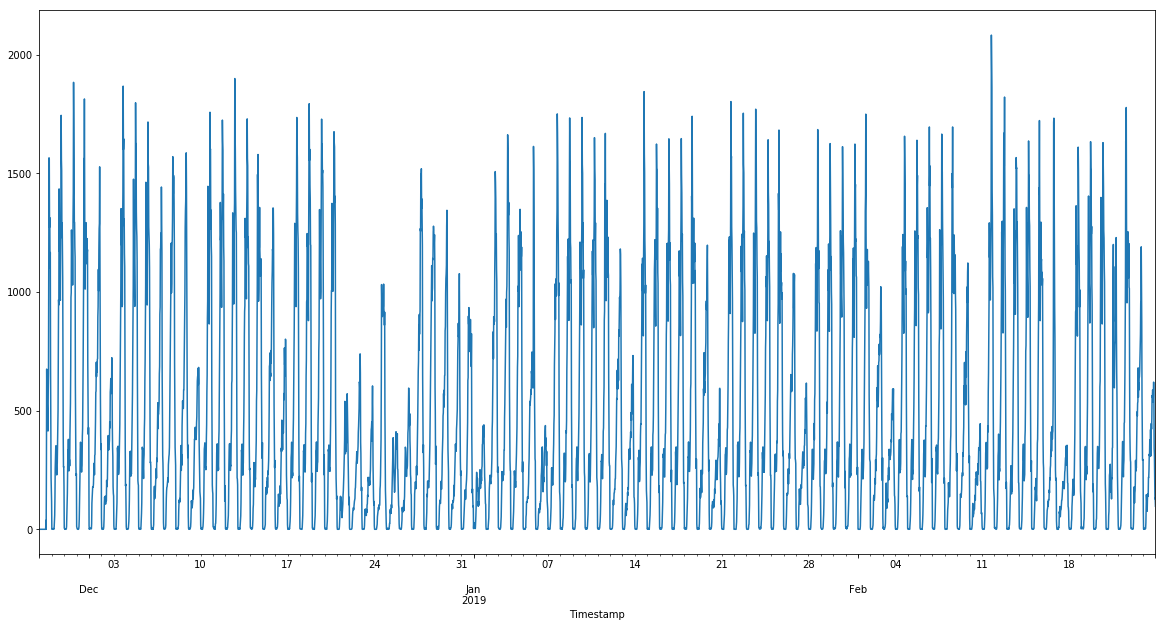

In [38]:
ravn_df['TotalEntries'].plot()
plt.show()

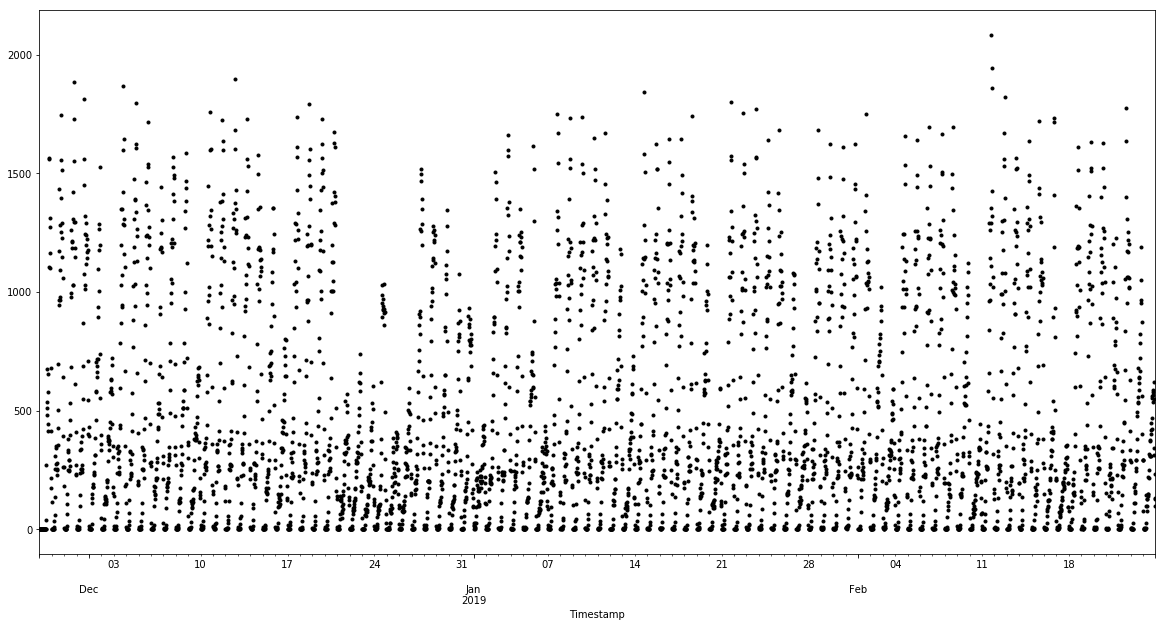

In [39]:
# Let's see the distribution/density of the observations as dots:

ravn_df['TotalEntries'].plot(style='k.')
plt.show()

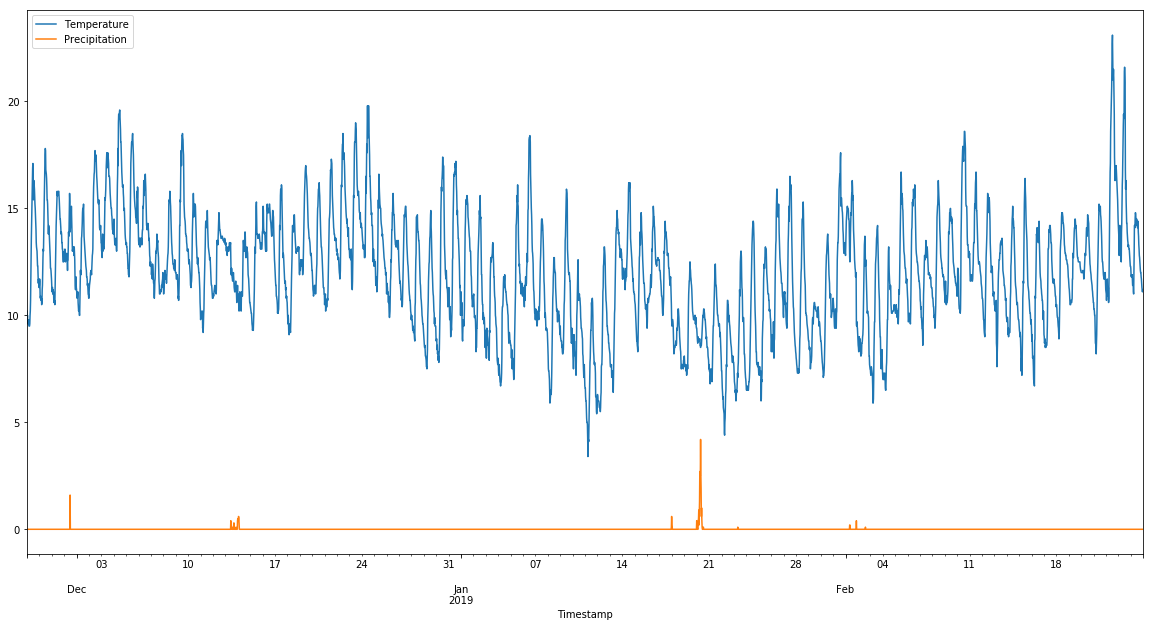

In [40]:
# Weather time series plot

ravn_df[['Temperature', 'Precipitation']].plot()
plt.show()

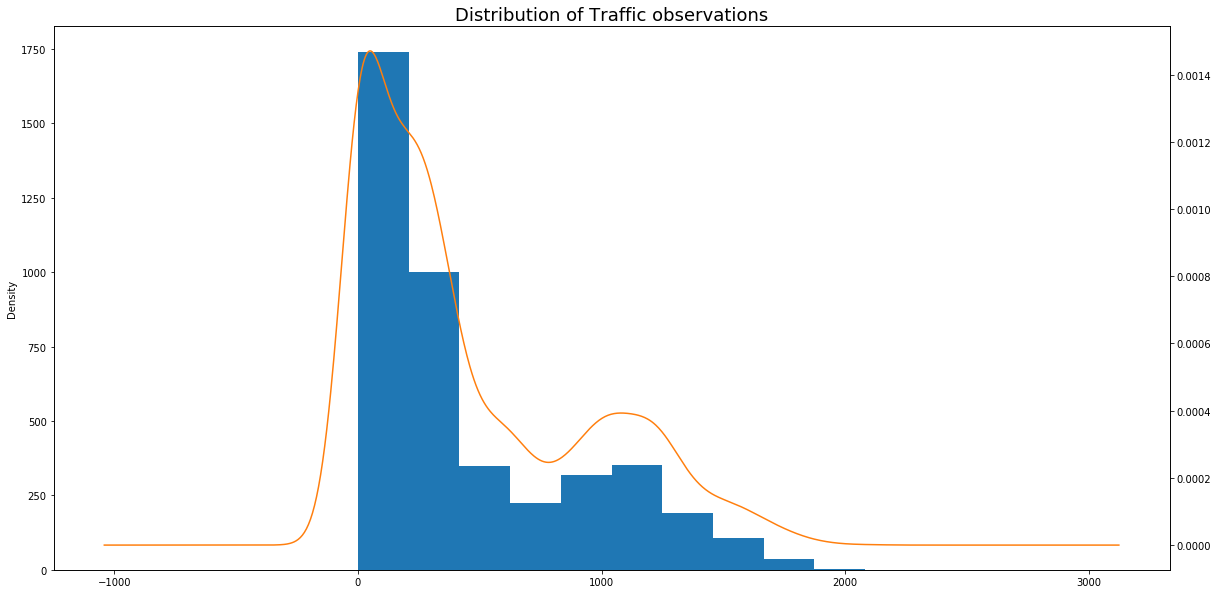

In [41]:
# Traffic observations distribution

ax = ravn_df['TotalEntries'].hist()
ravn_df.TotalEntries.plot(kind='kde', ax=ax, secondary_y=True)
plt.title('Distribution of Traffic observations', fontsize=18)
plt.show()

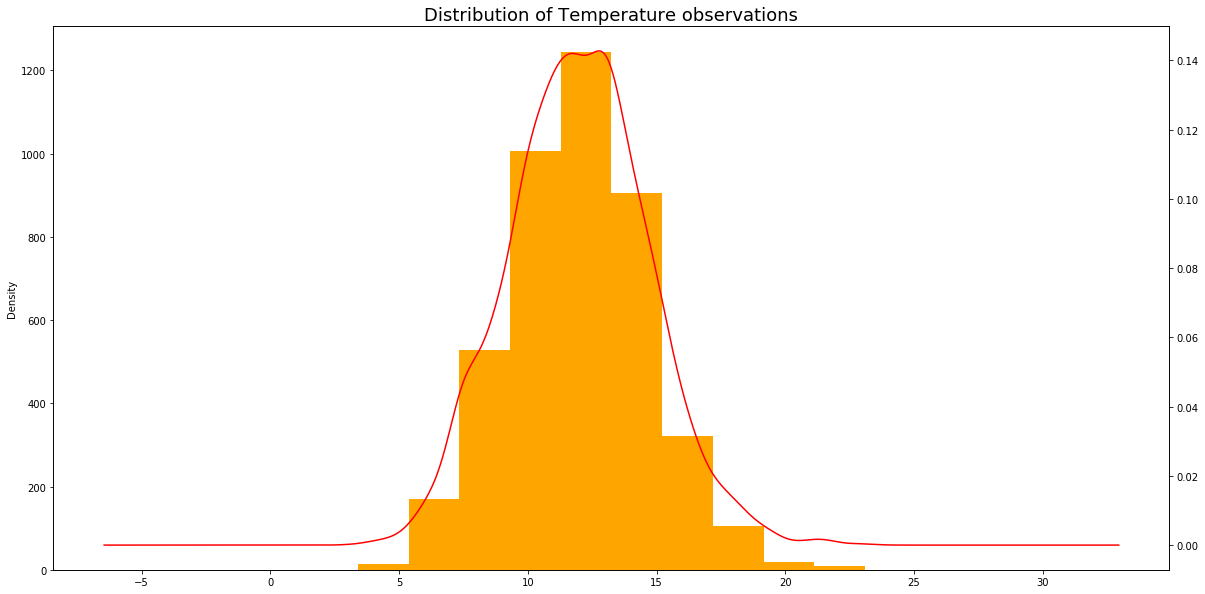

In [42]:
# Temperature observations distribution

ax = ravn_df['Temperature'].hist(color='orange')
ravn_df.Temperature.plot(kind='kde', color='red', ax=ax, secondary_y=True)
plt.title('Distribution of Temperature observations', fontsize=18)
plt.show()

Since there was precipitiation in just a few timestamps, thre's no point in plotting the precipitation observations distribution (it would be mostly 0).

In [43]:
# Let's plot the TotalEntries data segregated by months to get an idea of its distribution:

ravn_groups = ravn_df['TotalEntries'].groupby(pd.Grouper(freq= 'M'))
ravn_months = pd.concat([pd.DataFrame(x[1].values) for x in ravn_groups], axis = 1)
ravn_months.columns = ['Nov', 'Dec', 'Jan', 'Feb']
ravn_months.head()

,Nov,Dec,Jan,Feb
0,0.0,15,3,1.0
1,0.0,0,27,0.0
2,0.0,5,19,0.0
3,0.0,2,15,0.0
4,0.0,5,8,0.0


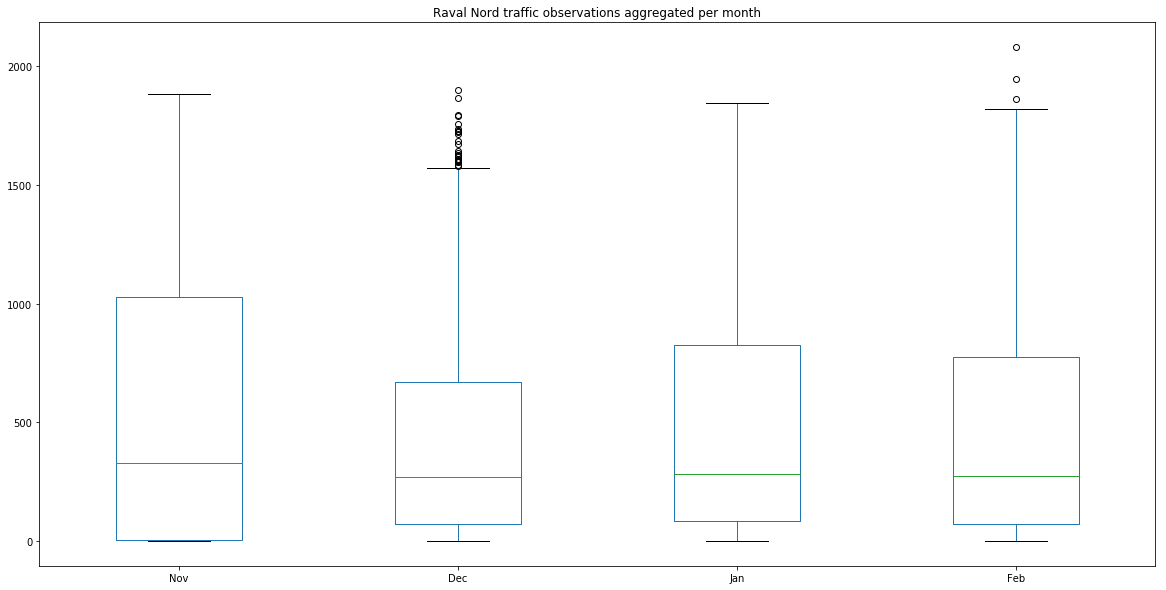

In [44]:
ravn_months.plot(kind='box', title='Raval Nord traffic observations aggregated per month')
plt.show()

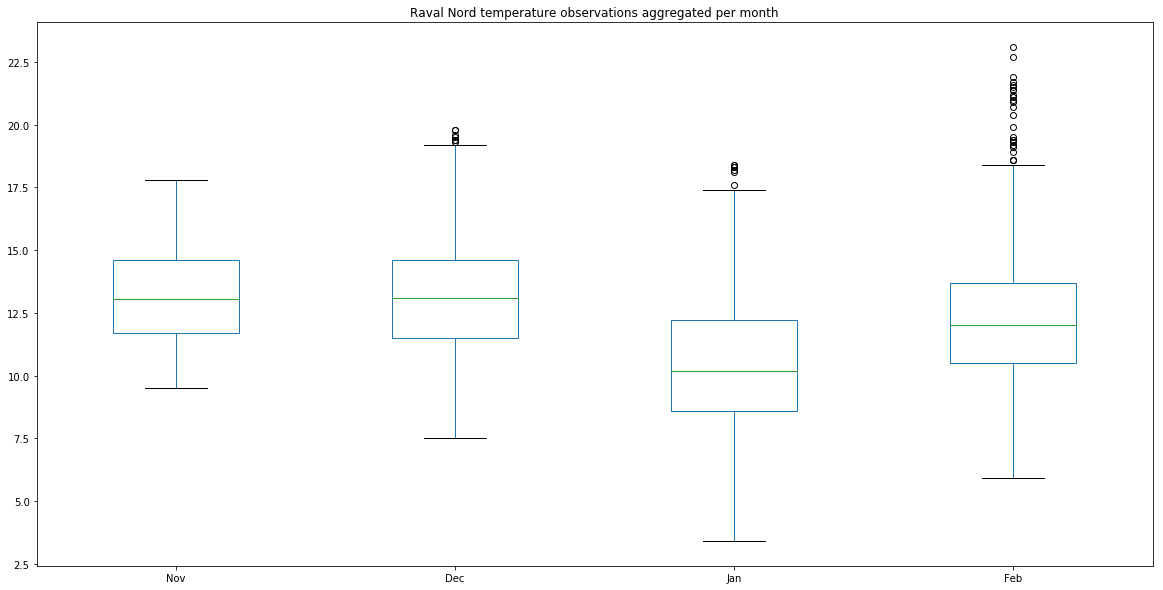

In [45]:
# Let's plot the Temperature and Precipitation data segregated by months to get an idea of its distribution:

ravn_temp_groups = ravn_df['Temperature'].groupby(pd.Grouper(freq= 'M'))
ravn_prec_groups = ravn_df['Precipitation'].groupby(pd.Grouper(freq= 'M'))
ravn_temp_months = pd.concat([pd.DataFrame(x[1].values) for x in ravn_temp_groups], axis = 1)
ravn_prec_months = pd.concat([pd.DataFrame(x[1].values) for x in ravn_prec_groups], axis = 1)
ravn_temp_months.columns = ['Nov', 'Dec', 'Jan', 'Feb']
ravn_prec_months.columns = ['Nov', 'Dec', 'Jan', 'Feb']

ravn_temp_months.plot(kind='box', title='Raval Nord temperature observations aggregated per month')
plt.show()

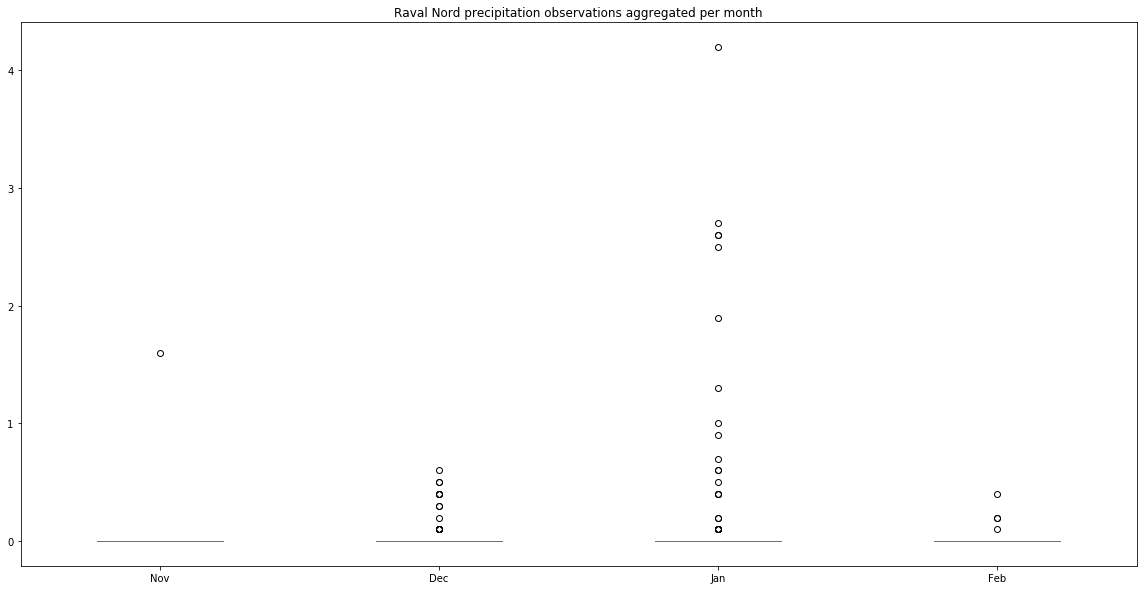

In [46]:
ravn_prec_months.plot(kind='box', title='Raval Nord precipitation observations aggregated per month')
plt.show()

Distribution of Traffic data along months


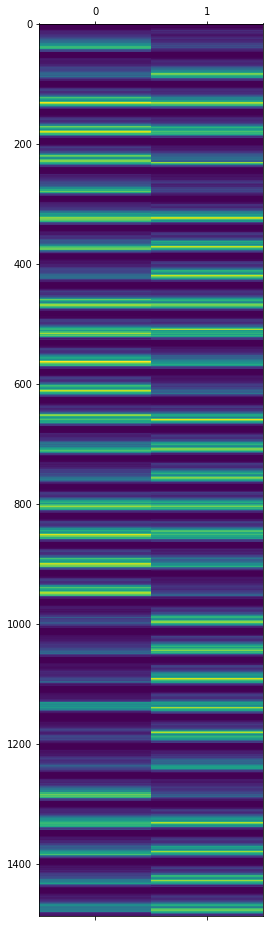

In [47]:
# Heatmap, to get an idea of the distribution of the traffic data along the months.

print('Distribution of Traffic data along months')
plt.matshow(ravn_months[['Dec', 'Jan']], interpolation=None, aspect='auto')
plt.show()

On the heatmap, each day can be observed as a 'cilinder', and a regular week can be observed as a series of 5 brigther cilinders followed by 2 darker ones. This highlights a higher people traffic during working days compared to the weekends. If confirmed on the other series, might be a good idea to include a binary feature working_day/weekend_day. The granularity of the data allows for the perception of relief. 

## Exploring correlations between variables

In order to analyze correlations properly, first of all it would be necessary to exclude the rows of closed hours. Otherwise the analysis could lead us to the wrong conclusions.

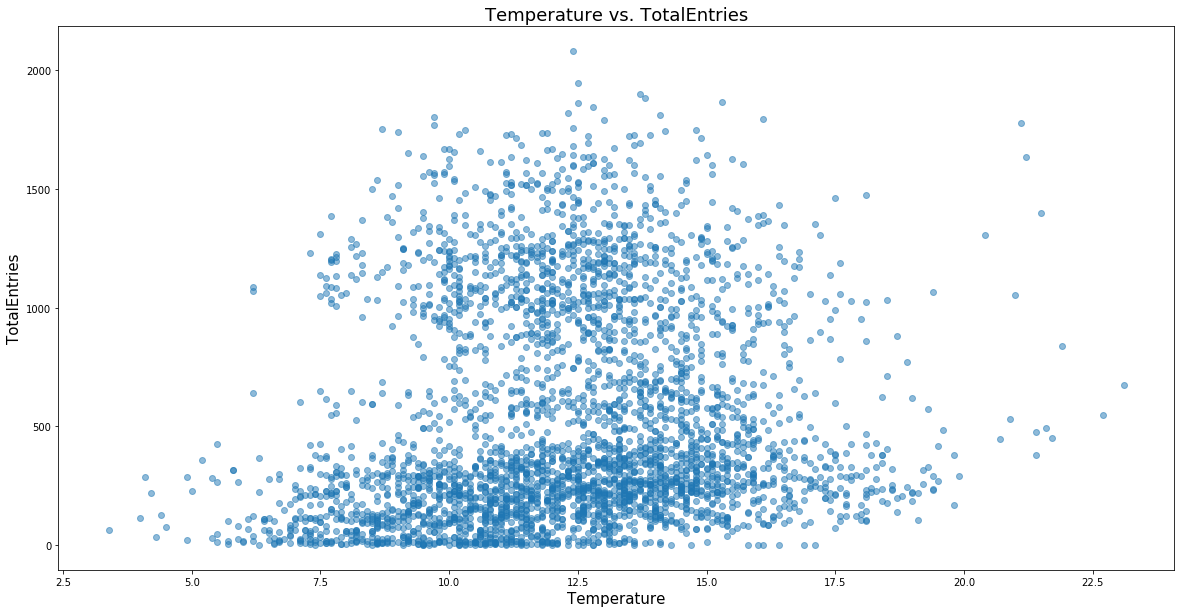

In [48]:
plt.scatter(ravn_df['Temperature'][ravn_df['Open/Closed'] == 1], ravn_df['TotalEntries'][ravn_df['Open/Closed'] == 1], alpha=0.5)
plt.title('Temperature vs. TotalEntries', fontsize=18)
plt.xlabel('Temperature', fontsize=15)
plt.ylabel('TotalEntries', fontsize=15)
plt.show()

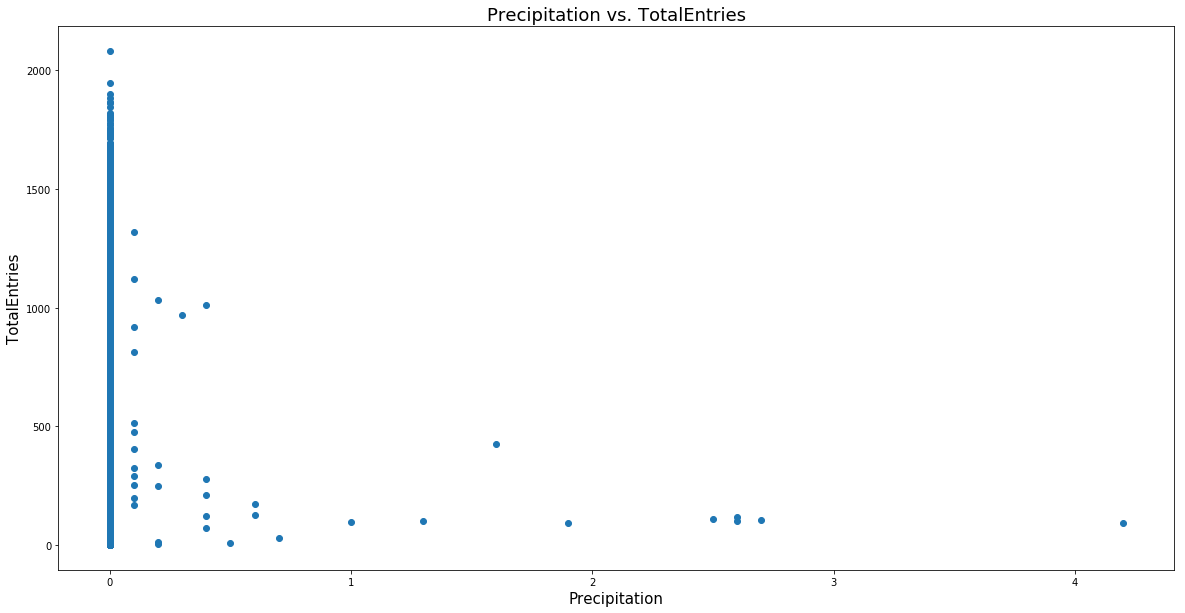

In [49]:
plt.scatter(ravn_df['Precipitation'][ravn_df['Open/Closed'] == 1], ravn_df['TotalEntries'][ravn_df['Open/Closed'] == 1])
plt.title('Precipitation vs. TotalEntries', fontsize=18)
plt.xlabel('Precipitation', fontsize=15)
plt.ylabel('TotalEntries', fontsize=15)
plt.show()

In [50]:
ravn_df.corr()

,TotalEntries,Temperature,Precipitation,Open/Closed
TotalEntries,1.000000,0.223908,-0.040406,0.432701
Temperature,0.223908,1.000000,-0.059101,0.300990
Precipitation,-0.040406,-0.059101,1.000000,0.005616
Open/Closed,0.432701,0.300990,0.005616,1.000000


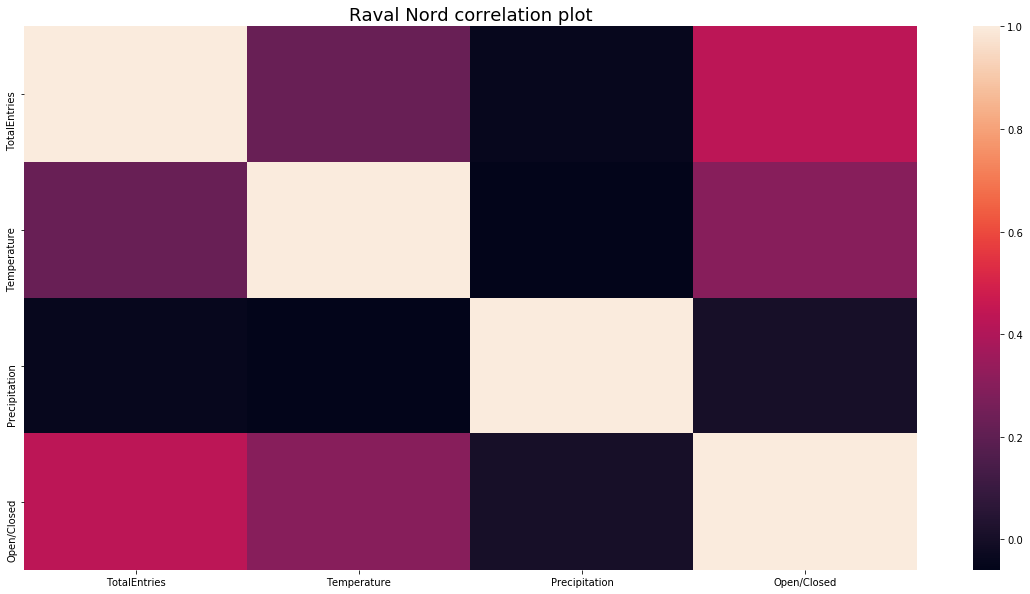

In [51]:
sns.heatmap(ravn_df.corr())
plt.title('Raval Nord correlation plot', fontsize=18)
plt.show()

## Autocorrelation and decomposition of the time series

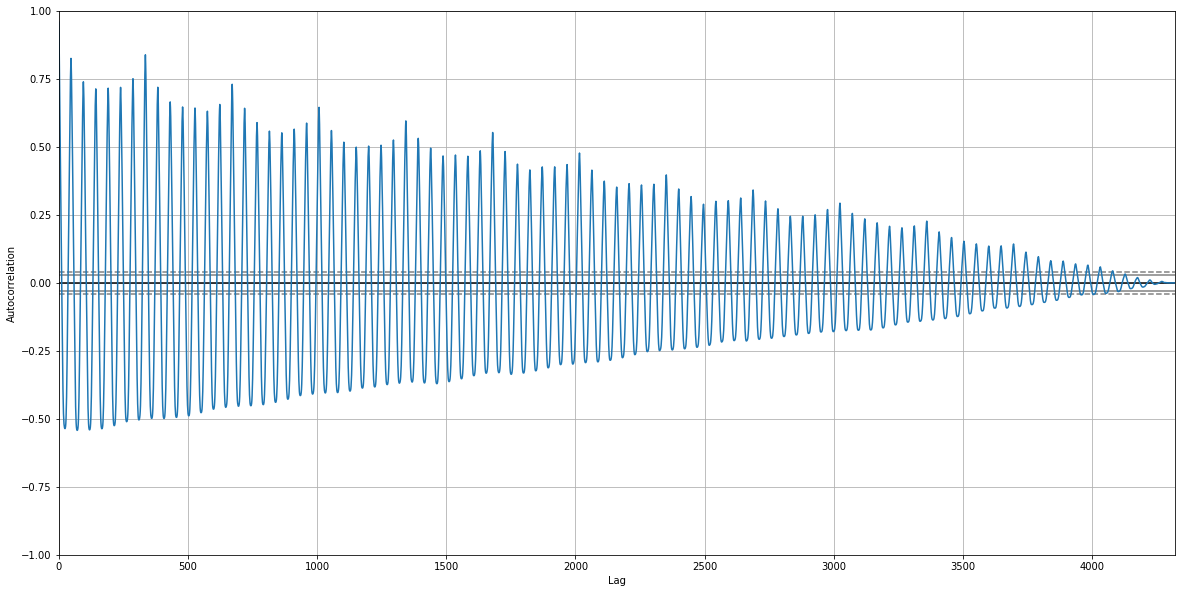

In [52]:
# People traffic autocorrelation plot

from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(20, 10))
autocorrelation_plot(ravn_df['TotalEntries'])
plt.show()

The autocorrelation plot suggests a strong correlation among weeks, that fades away after several week cycles. One week cycle consists of 336 observations. Let's create lags as possible features to check their correlation with the target variable (TotalEntries).

In [53]:
def append_lags(x, N):
    temp_df = x.copy()
    for i in range (1, N+1):
        temp_df['t-' + str(i)] = x['TotalEntries'].shift(i)
    return temp_df.iloc[N:]

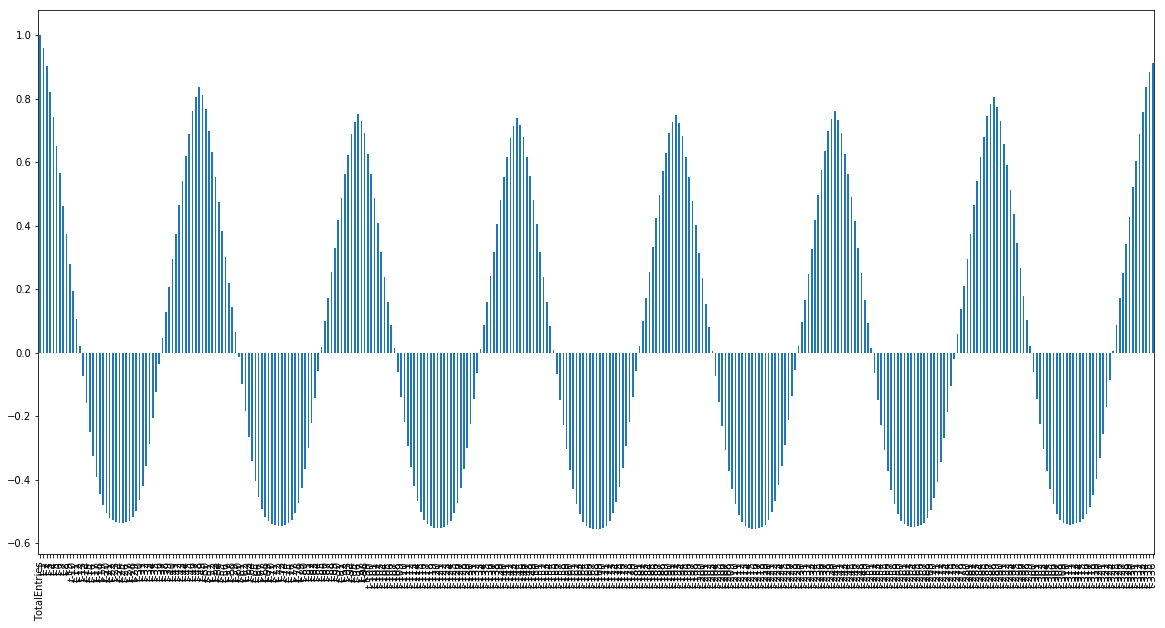

In [54]:
# Plotting correlation creating 1 week of lags:

ravn_lags = append_lags(ravn_df, (48*7))
plt.figure(figsize=(20, 10))
ravn_lags.drop(['Temperature', 'Precipitation', 'Open/Closed'], axis=1).corr()['TotalEntries'].plot(kind='bar')
plt.show()

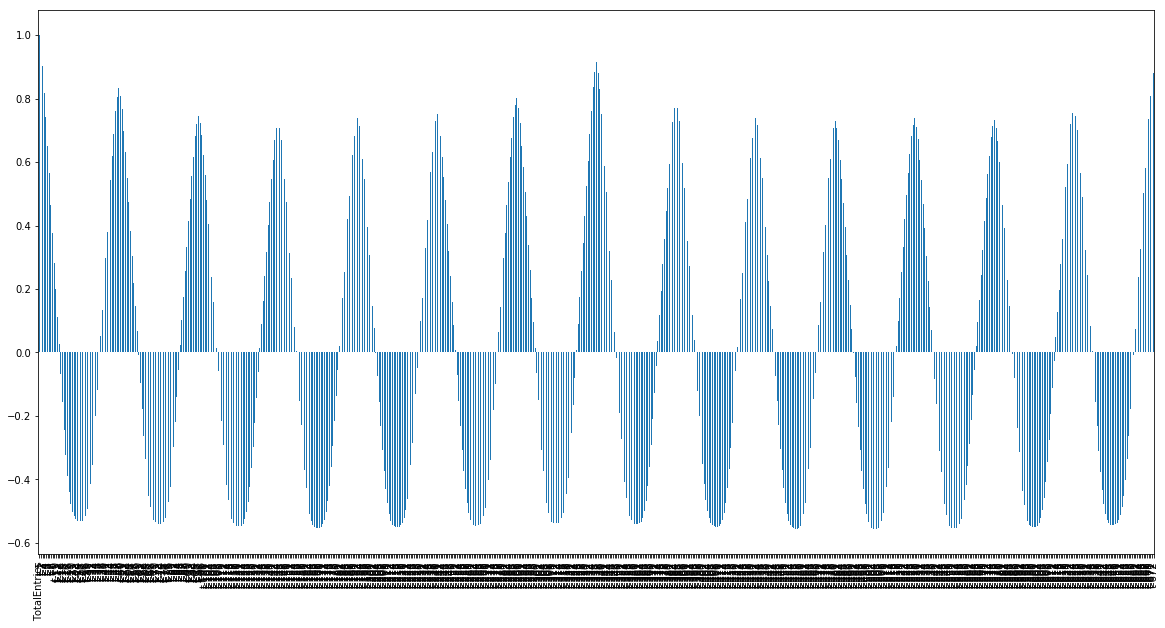

In [55]:
# Plotting correlation creating 2 weeks of lags:

ravn_lags = append_lags(ravn_df, (48*7*2))
plt.figure(figsize=(20, 10))
ravn_lags.drop(['Temperature', 'Precipitation', 'Open/Closed'], axis=1).corr()['TotalEntries'].plot(kind='bar')
plt.show()

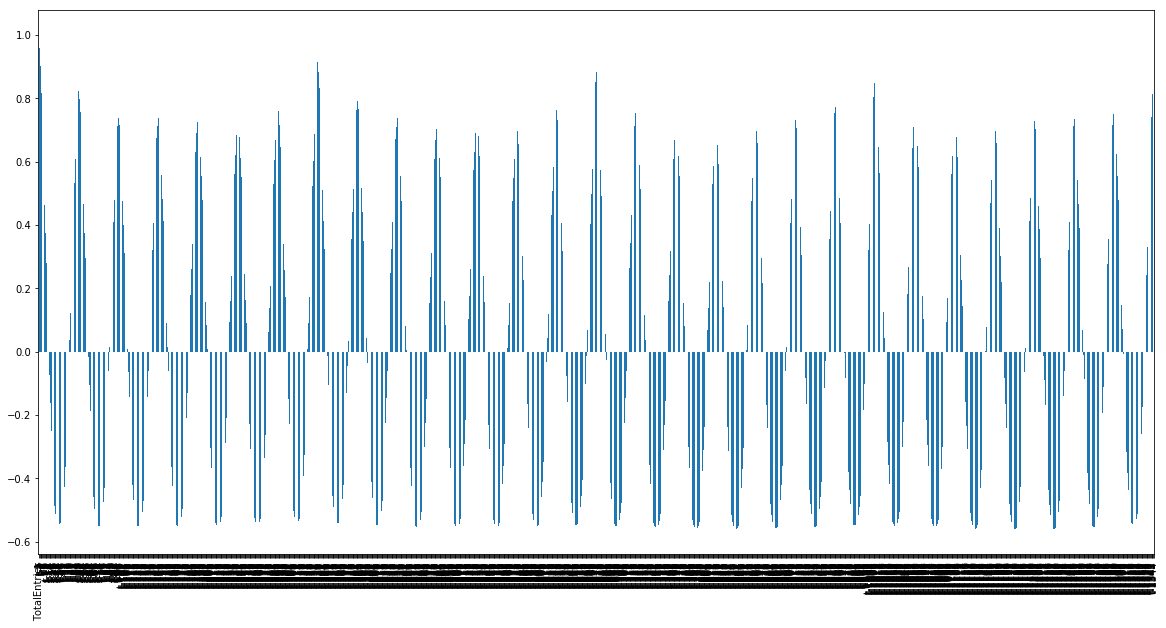

In [56]:
# Plotting correlation creating a month of lags:

ravn_lags = append_lags(ravn_df, (48*7*4))
plt.figure(figsize=(20, 10))
ravn_lags.drop(['Temperature', 'Precipitation', 'Open/Closed'], axis=1).corr()['TotalEntries'].plot(kind='bar')
plt.show()

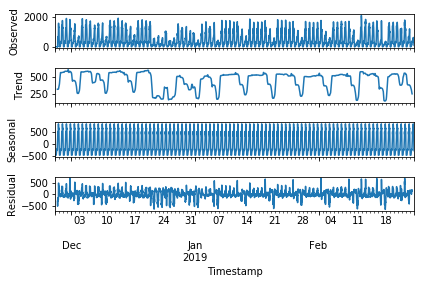

In [27]:
# Finally, let's decompose the time series assuming the seasonal component is additive and a frequency on 1 day:

ravn_ddec = seasonal_decompose(ravn_df['TotalEntries'].astype(np.float64), freq=(48))
ravn_ddec.plot()
plt.show()

Decomposing the series with a frequency of 1 day, the residual component seems to follow a pattern. Let's try a frequency of 1 week and 1 month.

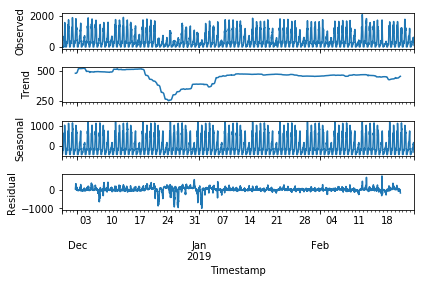

In [28]:
# Frequency of 1 week

ravn_wdec = seasonal_decompose(ravn_df['TotalEntries'].astype(np.float64), freq=(48*7))
ravn_wdec.plot()
plt.show()

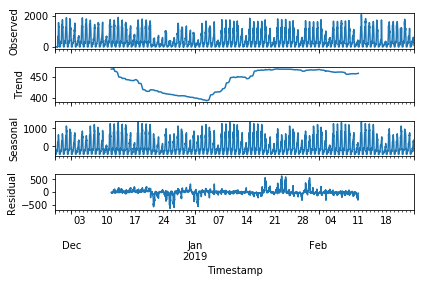

In [29]:
# Frequency of 1 month

ravn_wdec = seasonal_decompose(ravn_df['TotalEntries'].astype(np.float64), freq=(48*7*4))
ravn_wdec.plot()
plt.show()

In both weekly and monthly decomposition the residual component still shows a pattern. Based on the correlation plot, a weekly frequency decompostion seems to capture most of the information to be extracted.

### Outliers

In [30]:
ravn_df['TotalEntries'].sort_values(ascending=False).head(10)

Timestamp
2019-02-11 18:00:00    2082
2019-02-11 18:30:00    1945
2018-12-12 18:00:00    1899
2018-11-29 18:00:00    1883
2018-12-03 18:00:00    1867
2019-02-11 19:00:00    1861
2019-01-14 18:00:00    1844
2019-02-12 19:30:00    1821
2018-11-30 15:00:00    1813
2019-01-21 18:00:00    1802
Name: TotalEntries, dtype: int64

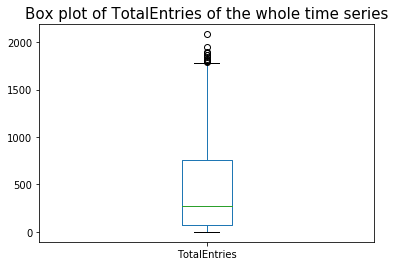

In [45]:
ravn_df['TotalEntries'].plot(kind='box')
plt.title('Box plot of TotalEntries of the whole time series', fontsize=15)
plt.show()

The higher TotalEntries values are observed on February. As observed by the line plot and the box-plot, they are scarce and not far from the main bulk of the observations. 

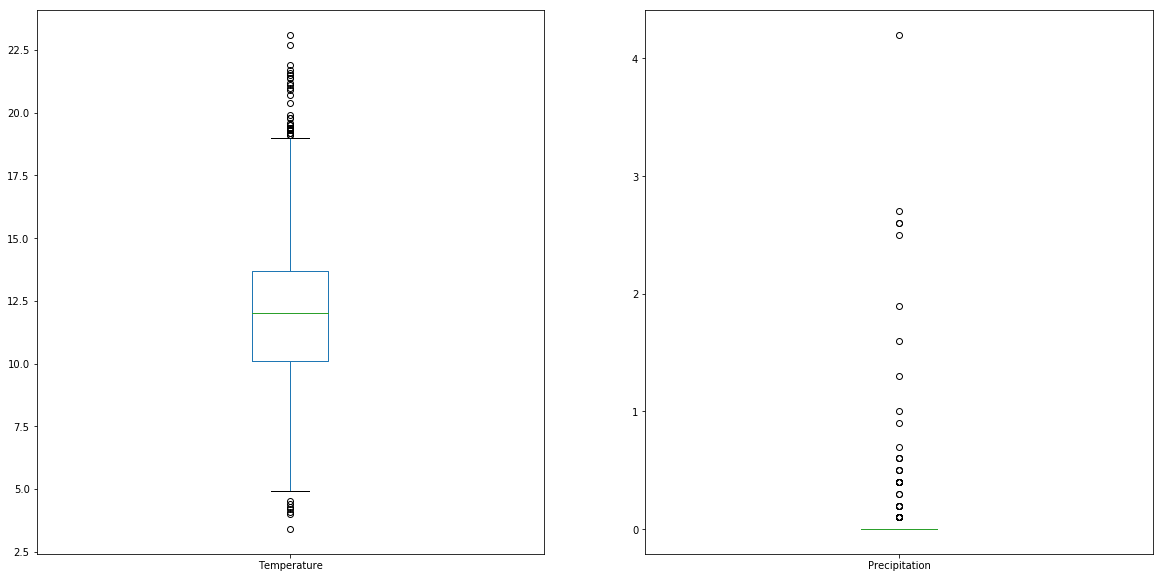

In [48]:
# Weather outliers

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ravn_df['Temperature'].plot(kind='box', ax=ax1)
ravn_df['Precipitation'].plot(kind='box', ax=ax2)
plt.show()

In [52]:
ravn_df[ravn_df['Precipitation'] != 0].shape[0]

46

As seen in the line plot, the Temperature feature show its peak on february but the outliers are not very extreme. The precipitation feature just have 46 observations different of 0 out of 4320 total observations, so no conclusions can be extracted.

In [32]:
ravn_df.to_csv('./../../../Databases/ravaln_data.csv', index=True)